# 🧱 DCGAN - Bricks Data

- Estudiante: Lenin G. Falconí

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [17]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

# from notebooks.utils import display, sample_batch

from scipy.stats import norm



## 0. Parameters <a name="parameters"></a>

In [36]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 30
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [5]:
train_data = utils.image_dataset_from_directory(
    "/kaggle/input/lego-brick-images/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


In [18]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [19]:
# from source code
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [21]:
train_sample = sample_batch(train)

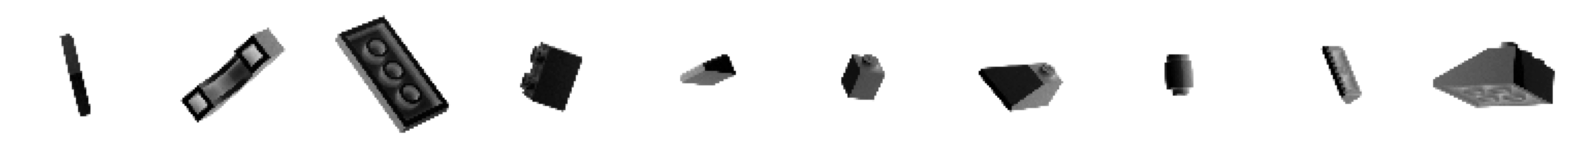

In [22]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [23]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [24]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │           1,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [26]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [35]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.keras")

## 3. Train the GAN <a name="train"></a>

In [28]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [33]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",
    # save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

In [34]:
import os
os.makedirs('./output', exist_ok=True)
os.makedirs('./models', exist_ok=True)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_acc: 0.8301 - d_fake_acc: 0.8307 - d_loss: 0.2934 - d_real_acc: 0.8296 - g_acc: 0.1693 - g_loss: 3.6634

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Saved to ./output/generated_img_000.png


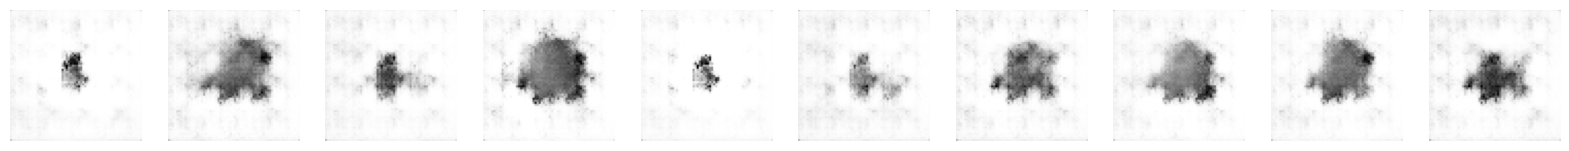

313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 151ms/step - d_acc: 0.8301 - d_fake_acc: 0.8307 - d_loss: 0.2933 - d_real_acc: 0.8296 - g_acc: 0.1693 - g_loss: 3.6630
Epoch 2/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9028 - d_fake_acc: 0.9091 - d_loss: 0.0492 - d_real_acc: 0.8966 - g_acc: 0.0909 - g_loss: 4.3181
Saved to ./output/generated_img_001.png


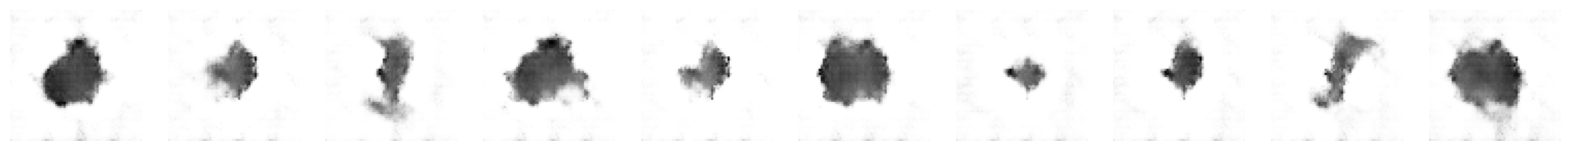

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9028 - d_fake_acc: 0.9090 - d_loss: 0.0493 - d_real_acc: 0.8965 - g_acc: 0.0910 - g_loss: 4.3200
Epoch 3/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.8782 - d_fake_acc: 0.8838 - d_loss: 0.1159 - d_real_acc: 0.8727 - g_acc: 0.1162 - g_loss: 4.8941
Saved to ./output/generated_img_002.png


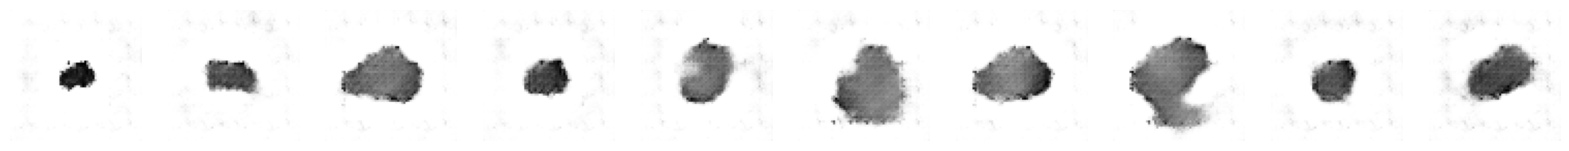

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - d_acc: 0.8783 - d_fake_acc: 0.8839 - d_loss: 0.1157 - d_real_acc: 0.8728 - g_acc: 0.1161 - g_loss: 4.8957
Epoch 4/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.8762 - d_fake_acc: 0.8726 - d_loss: 0.1413 - d_real_acc: 0.8798 - g_acc: 0.1274 - g_loss: 4.4032
Saved to ./output/generated_img_003.png


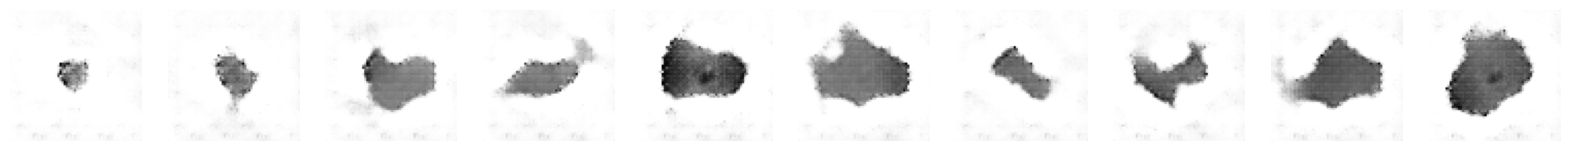

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - d_acc: 0.8762 - d_fake_acc: 0.8726 - d_loss: 0.1414 - d_real_acc: 0.8797 - g_acc: 0.1274 - g_loss: 4.4035
Epoch 5/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.8880 - d_fake_acc: 0.8905 - d_loss: 0.1125 - d_real_acc: 0.8856 - g_acc: 0.1095 - g_loss: 4.1007
Saved to ./output/generated_img_004.png


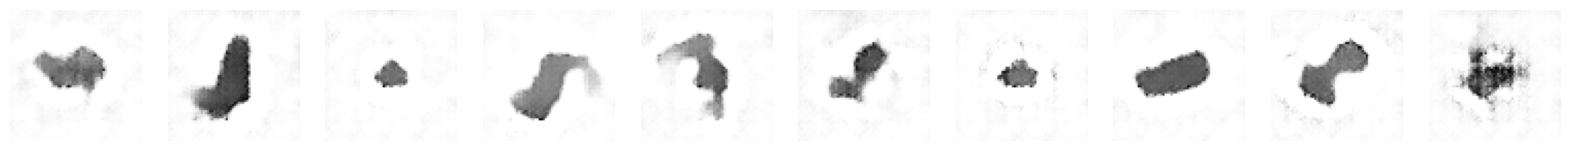

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - d_acc: 0.8880 - d_fake_acc: 0.8904 - d_loss: 0.1127 - d_real_acc: 0.8855 - g_acc: 0.1096 - g_loss: 4.1004
Epoch 6/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.8860 - d_fake_acc: 0.8848 - d_loss: 0.0992 - d_real_acc: 0.8872 - g_acc: 0.1152 - g_loss: 4.2169
Saved to ./output/generated_img_005.png


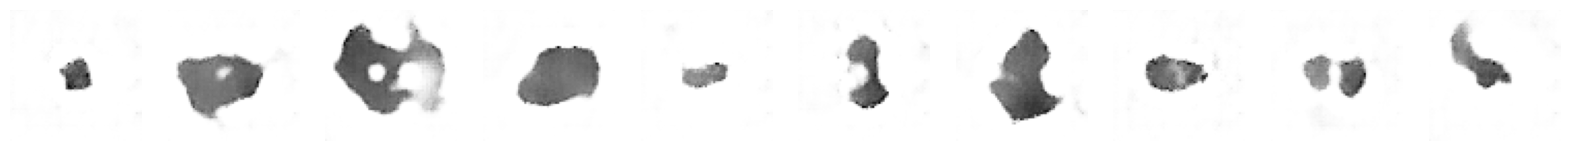

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - d_acc: 0.8860 - d_fake_acc: 0.8848 - d_loss: 0.0992 - d_real_acc: 0.8871 - g_acc: 0.1152 - g_loss: 4.2167
Epoch 7/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_acc: 0.8904 - d_fake_acc: 0.8919 - d_loss: 0.0963 - d_real_acc: 0.8890 - g_acc: 0.1081 - g_loss: 4.3673
Saved to ./output/generated_img_006.png


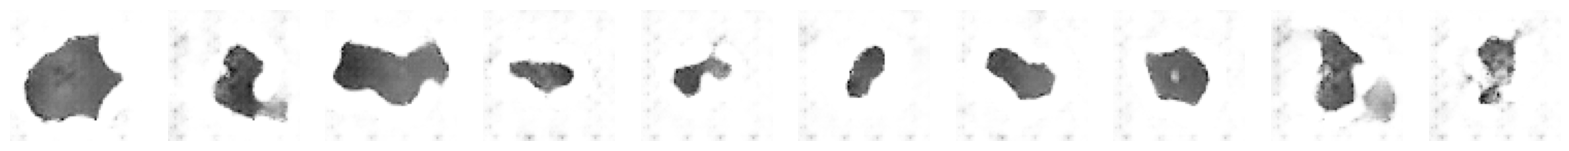

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - d_acc: 0.8904 - d_fake_acc: 0.8918 - d_loss: 0.0963 - d_real_acc: 0.8890 - g_acc: 0.1082 - g_loss: 4.3676
Epoch 8/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.8949 - d_fake_acc: 0.8970 - d_loss: 0.0966 - d_real_acc: 0.8929 - g_acc: 0.1030 - g_loss: 4.1509
Saved to ./output/generated_img_007.png


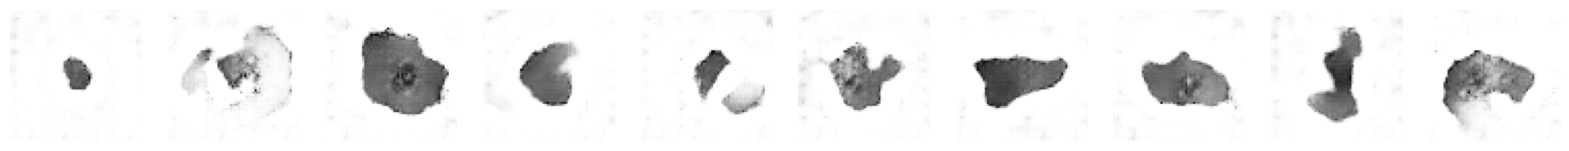

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.8949 - d_fake_acc: 0.8969 - d_loss: 0.0966 - d_real_acc: 0.8929 - g_acc: 0.1031 - g_loss: 4.1517
Epoch 9/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.8992 - d_fake_acc: 0.8994 - d_loss: 0.0728 - d_real_acc: 0.8989 - g_acc: 0.1006 - g_loss: 4.5286
Saved to ./output/generated_img_008.png


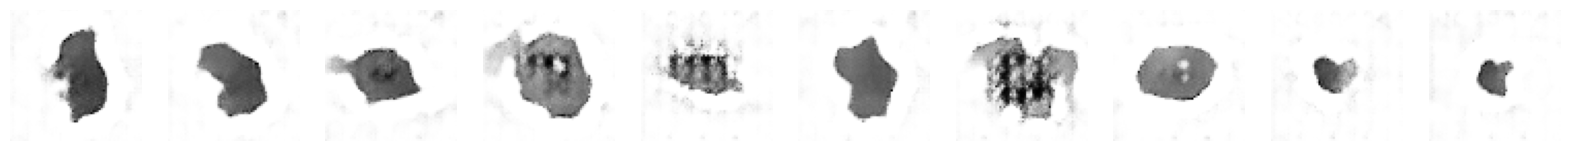

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.8991 - d_fake_acc: 0.8993 - d_loss: 0.0730 - d_real_acc: 0.8989 - g_acc: 0.1007 - g_loss: 4.5279
Epoch 10/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9124 - d_fake_acc: 0.9126 - d_loss: 0.0106 - d_real_acc: 0.9121 - g_acc: 0.0874 - g_loss: 4.8140
Saved to ./output/generated_img_009.png


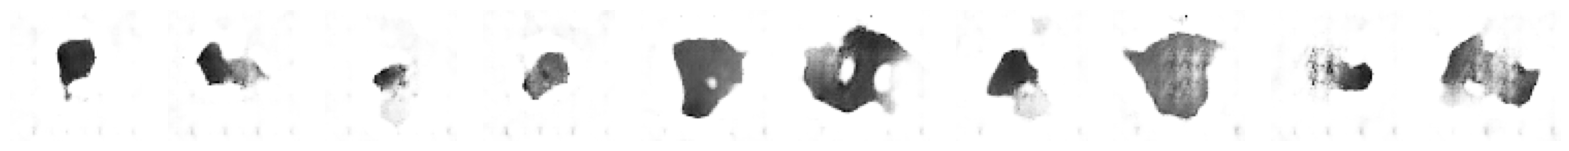

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9124 - d_fake_acc: 0.9126 - d_loss: 0.0106 - d_real_acc: 0.9121 - g_acc: 0.0874 - g_loss: 4.8151
Epoch 11/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.9108 - d_fake_acc: 0.9110 - d_loss: 0.0403 - d_real_acc: 0.9105 - g_acc: 0.0890 - g_loss: 5.0406
Saved to ./output/generated_img_010.png


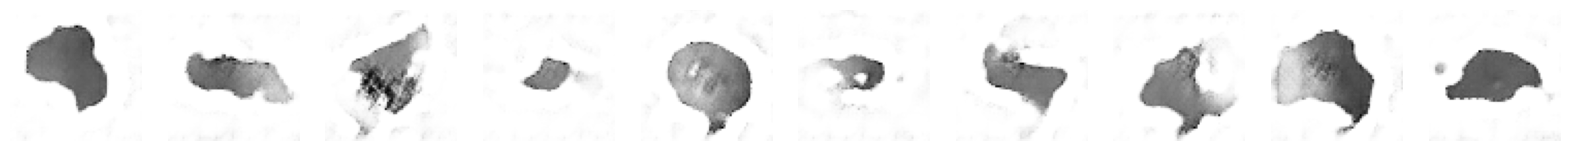

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - d_acc: 0.9107 - d_fake_acc: 0.9110 - d_loss: 0.0406 - d_real_acc: 0.9104 - g_acc: 0.0890 - g_loss: 5.0394
Epoch 12/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9315 - d_fake_acc: 0.9314 - d_loss: -0.0286 - d_real_acc: 0.9316 - g_acc: 0.0686 - g_loss: 5.2427
Saved to ./output/generated_img_011.png


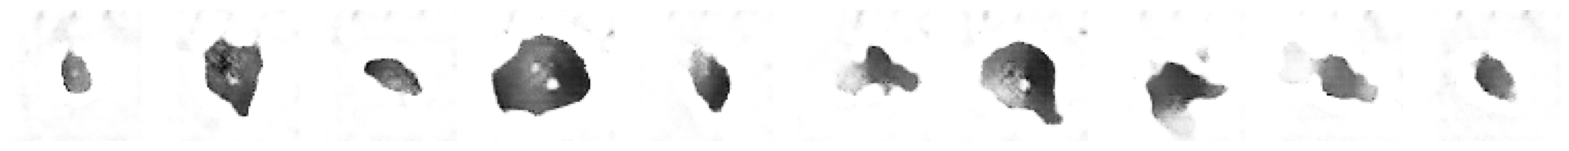

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9314 - d_fake_acc: 0.9313 - d_loss: -0.0282 - d_real_acc: 0.9315 - g_acc: 0.0687 - g_loss: 5.2418
Epoch 13/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9233 - d_fake_acc: 0.9215 - d_loss: -5.6555e-05 - d_real_acc: 0.9251 - g_acc: 0.0785 - g_loss: 5.1424
Saved to ./output/generated_img_012.png


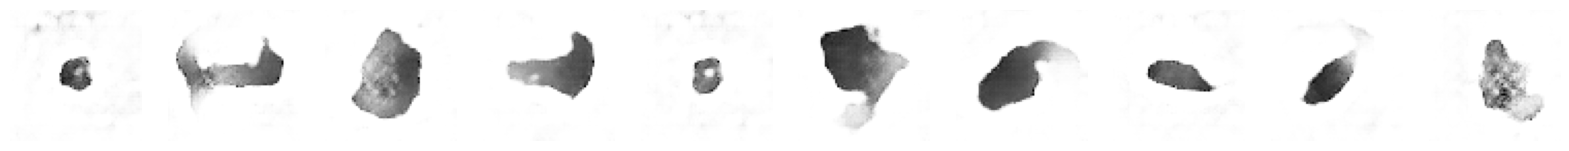

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - d_acc: 0.9233 - d_fake_acc: 0.9215 - d_loss: -6.5117e-05 - d_real_acc: 0.9251 - g_acc: 0.0785 - g_loss: 5.1432
Epoch 14/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.9210 - d_fake_acc: 0.9232 - d_loss: -0.0028 - d_real_acc: 0.9188 - g_acc: 0.0768 - g_loss: 5.4184
Saved to ./output/generated_img_013.png


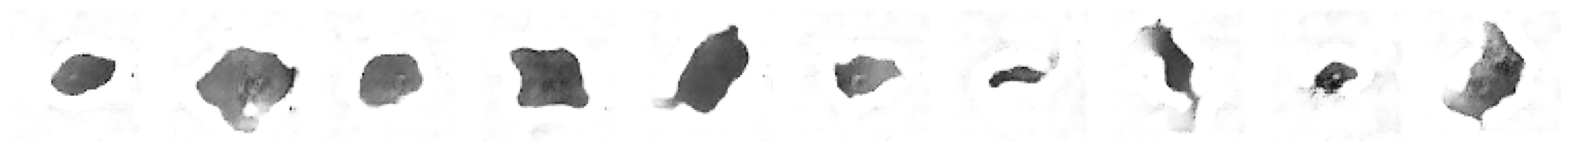

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - d_acc: 0.9209 - d_fake_acc: 0.9231 - d_loss: -0.0026 - d_real_acc: 0.9188 - g_acc: 0.0769 - g_loss: 5.4174
Epoch 15/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9024 - d_fake_acc: 0.9010 - d_loss: 0.0623 - d_real_acc: 0.9039 - g_acc: 0.0990 - g_loss: 5.5159
Saved to ./output/generated_img_014.png


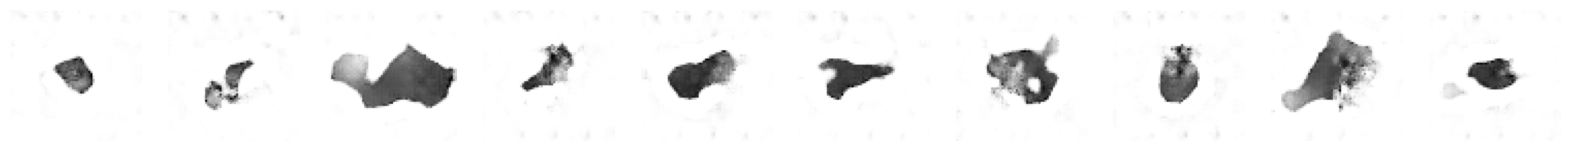

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9025 - d_fake_acc: 0.9011 - d_loss: 0.0619 - d_real_acc: 0.9039 - g_acc: 0.0989 - g_loss: 5.5154
Epoch 16/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_acc: 0.9119 - d_fake_acc: 0.9111 - d_loss: 0.0154 - d_real_acc: 0.9127 - g_acc: 0.0889 - g_loss: 6.0007
Saved to ./output/generated_img_015.png


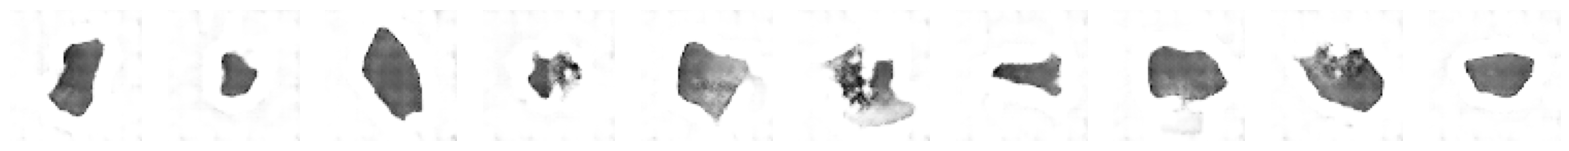

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - d_acc: 0.9119 - d_fake_acc: 0.9111 - d_loss: 0.0155 - d_real_acc: 0.9127 - g_acc: 0.0889 - g_loss: 5.9989
Epoch 17/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9350 - d_fake_acc: 0.9336 - d_loss: -0.0423 - d_real_acc: 0.9365 - g_acc: 0.0664 - g_loss: 5.7252
Saved to ./output/generated_img_016.png


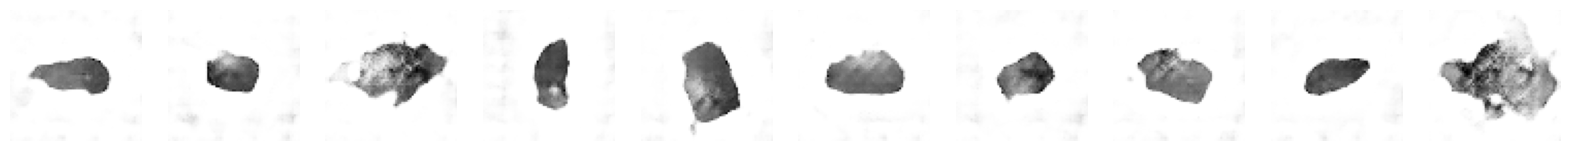

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - d_acc: 0.9349 - d_fake_acc: 0.9335 - d_loss: -0.0419 - d_real_acc: 0.9364 - g_acc: 0.0665 - g_loss: 5.7249
Epoch 18/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9356 - d_fake_acc: 0.9354 - d_loss: -0.0710 - d_real_acc: 0.9359 - g_acc: 0.0646 - g_loss: 5.5228
Saved to ./output/generated_img_017.png


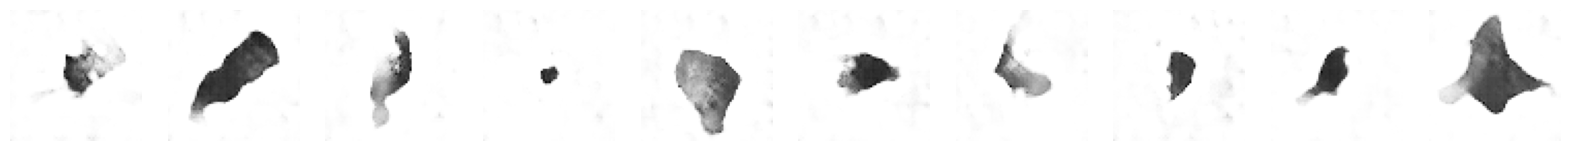

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - d_acc: 0.9356 - d_fake_acc: 0.9354 - d_loss: -0.0709 - d_real_acc: 0.9358 - g_acc: 0.0646 - g_loss: 5.5239
Epoch 19/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.9265 - d_fake_acc: 0.9257 - d_loss: 0.0510 - d_real_acc: 0.9272 - g_acc: 0.0743 - g_loss: 5.9326
Saved to ./output/generated_img_018.png


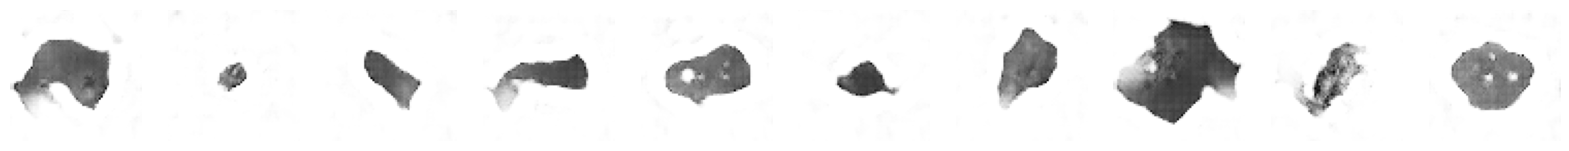

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9264 - d_fake_acc: 0.9257 - d_loss: 0.0511 - d_real_acc: 0.9272 - g_acc: 0.0743 - g_loss: 5.9326
Epoch 20/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9324 - d_fake_acc: 0.9350 - d_loss: -0.0527 - d_real_acc: 0.9298 - g_acc: 0.0650 - g_loss: 5.7501
Saved to ./output/generated_img_019.png


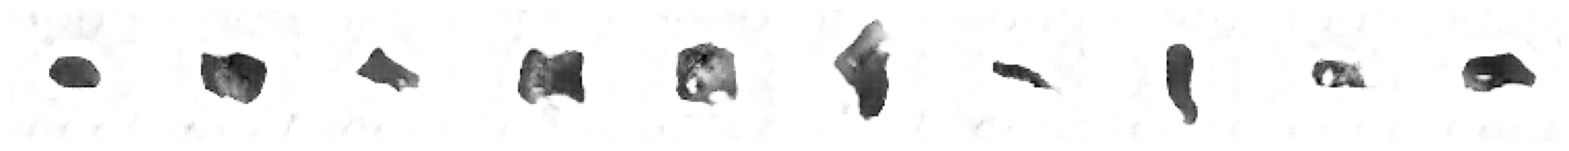

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - d_acc: 0.9325 - d_fake_acc: 0.9351 - d_loss: -0.0528 - d_real_acc: 0.9298 - g_acc: 0.0649 - g_loss: 5.7507
Epoch 21/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_acc: 0.9486 - d_fake_acc: 0.9501 - d_loss: -0.1729 - d_real_acc: 0.9472 - g_acc: 0.0499 - g_loss: 6.8637
Saved to ./output/generated_img_020.png


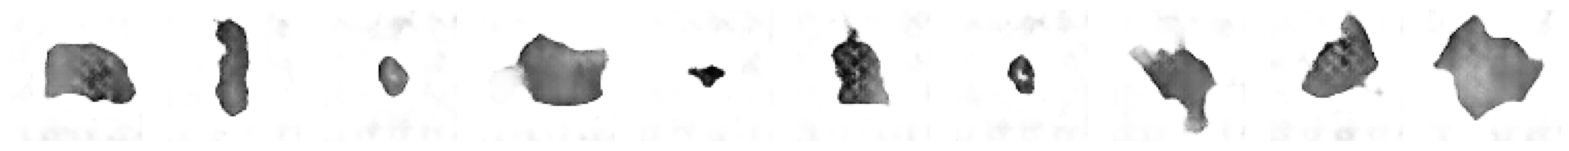

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - d_acc: 0.9486 - d_fake_acc: 0.9500 - d_loss: -0.1726 - d_real_acc: 0.9471 - g_acc: 0.0500 - g_loss: 6.8639
Epoch 22/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9420 - d_fake_acc: 0.9370 - d_loss: -0.0998 - d_real_acc: 0.9471 - g_acc: 0.0630 - g_loss: 6.6974
Saved to ./output/generated_img_021.png


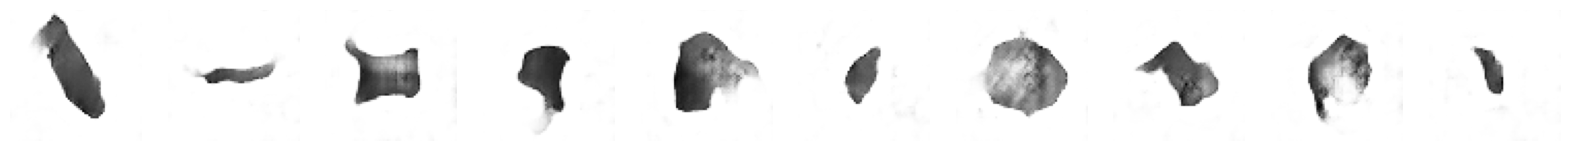

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9420 - d_fake_acc: 0.9370 - d_loss: -0.0997 - d_real_acc: 0.9471 - g_acc: 0.0630 - g_loss: 6.6977
Epoch 23/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9492 - d_fake_acc: 0.9493 - d_loss: -0.1890 - d_real_acc: 0.9490 - g_acc: 0.0507 - g_loss: 7.3671
Saved to ./output/generated_img_022.png


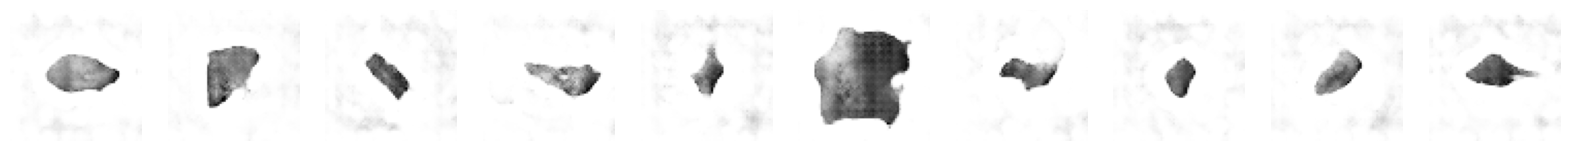

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9491 - d_fake_acc: 0.9492 - d_loss: -0.1887 - d_real_acc: 0.9490 - g_acc: 0.0508 - g_loss: 7.3674
Epoch 24/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9308 - d_fake_acc: 0.9308 - d_loss: -0.0481 - d_real_acc: 0.9307 - g_acc: 0.0692 - g_loss: 6.4158
Saved to ./output/generated_img_023.png


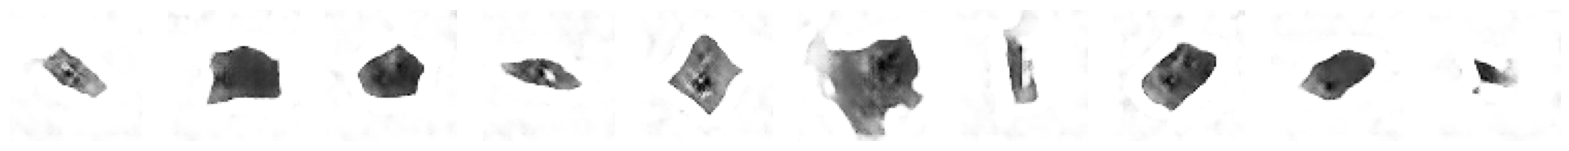

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9307 - d_fake_acc: 0.9308 - d_loss: -0.0476 - d_real_acc: 0.9307 - g_acc: 0.0692 - g_loss: 6.4168
Epoch 25/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_acc: 0.9581 - d_fake_acc: 0.9586 - d_loss: -0.1923 - d_real_acc: 0.9576 - g_acc: 0.0414 - g_loss: 6.9243
Saved to ./output/generated_img_024.png


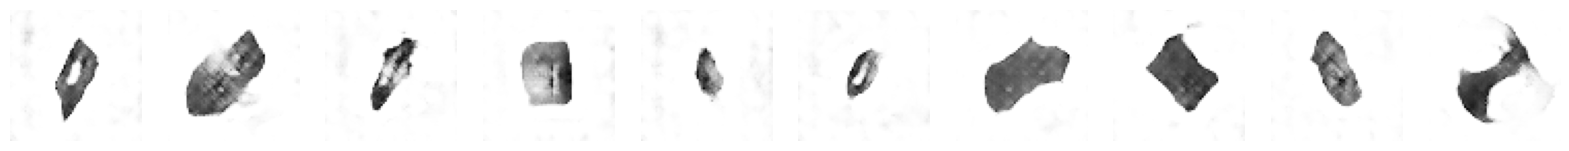

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - d_acc: 0.9580 - d_fake_acc: 0.9585 - d_loss: -0.1918 - d_real_acc: 0.9575 - g_acc: 0.0415 - g_loss: 6.9235
Epoch 26/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9517 - d_fake_acc: 0.9514 - d_loss: -0.1725 - d_real_acc: 0.9520 - g_acc: 0.0486 - g_loss: 7.1982
Saved to ./output/generated_img_025.png


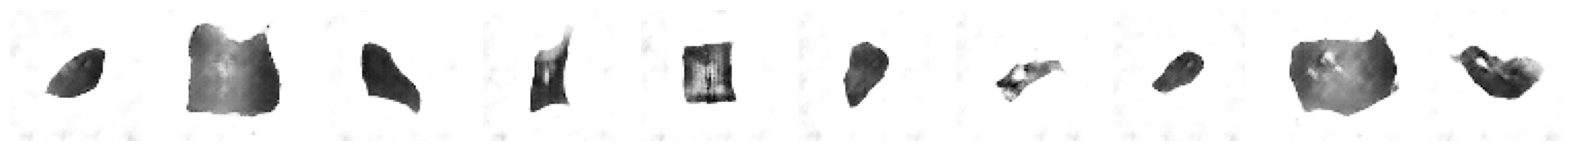

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9516 - d_fake_acc: 0.9513 - d_loss: -0.1720 - d_real_acc: 0.9518 - g_acc: 0.0487 - g_loss: 7.1956
Epoch 27/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.9362 - d_fake_acc: 0.9386 - d_loss: -0.0969 - d_real_acc: 0.9338 - g_acc: 0.0614 - g_loss: 7.1340
Saved to ./output/generated_img_026.png


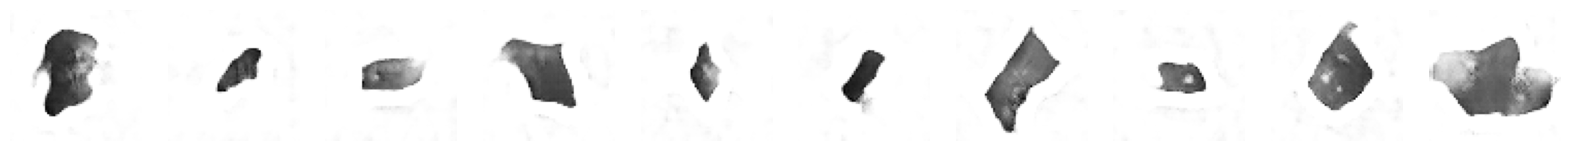

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - d_acc: 0.9362 - d_fake_acc: 0.9387 - d_loss: -0.0972 - d_real_acc: 0.9338 - g_acc: 0.0613 - g_loss: 7.1365
Epoch 28/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_acc: 0.9358 - d_fake_acc: 0.9358 - d_loss: -0.1255 - d_real_acc: 0.9357 - g_acc: 0.0642 - g_loss: 7.2364
Saved to ./output/generated_img_027.png


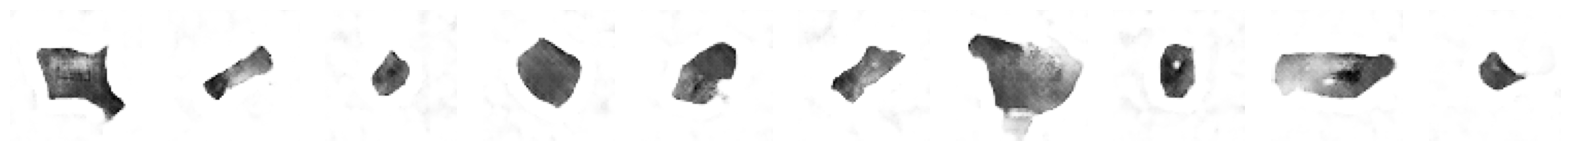

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - d_acc: 0.9357 - d_fake_acc: 0.9357 - d_loss: -0.1251 - d_real_acc: 0.9356 - g_acc: 0.0643 - g_loss: 7.2358
Epoch 29/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_acc: 0.9554 - d_fake_acc: 0.9544 - d_loss: -0.2126 - d_real_acc: 0.9565 - g_acc: 0.0456 - g_loss: 7.5319
Saved to ./output/generated_img_028.png


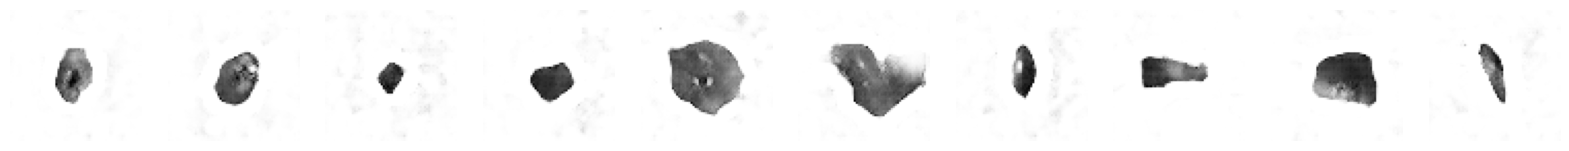

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.9554 - d_fake_acc: 0.9544 - d_loss: -0.2125 - d_real_acc: 0.9564 - g_acc: 0.0456 - g_loss: 7.5325
Epoch 30/30
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_acc: 0.8889 - d_fake_acc: 0.8900 - d_loss: 0.1799 - d_real_acc: 0.8879 - g_acc: 0.1100 - g_loss: 6.5630
Saved to ./output/generated_img_029.png


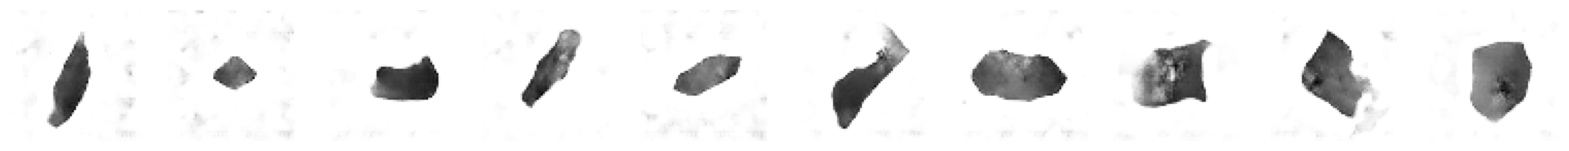

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - d_acc: 0.8892 - d_fake_acc: 0.8902 - d_loss: 0.1782 - d_real_acc: 0.8881 - g_acc: 0.1098 - g_loss: 6.5684


In [37]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [39]:
# Save the final models
generator.save("./models/generator.keras")
discriminator.save("./models/discriminator.keras")

## 3. Generate new images <a name="decode"></a>

In [40]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [41]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


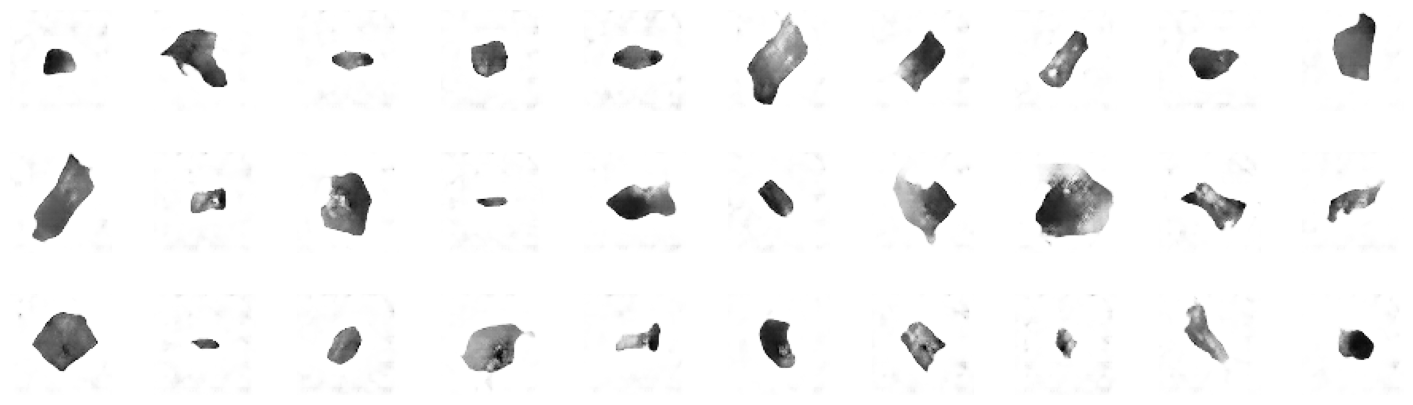

In [42]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [43]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [44]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


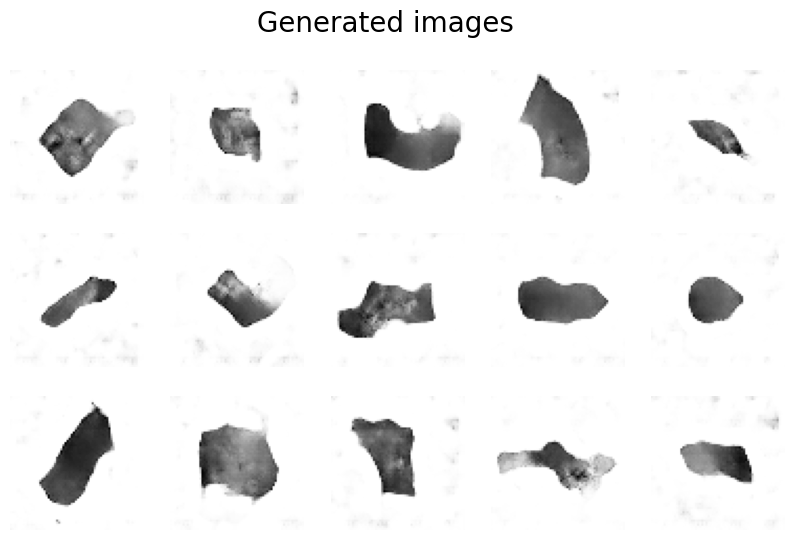

In [45]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

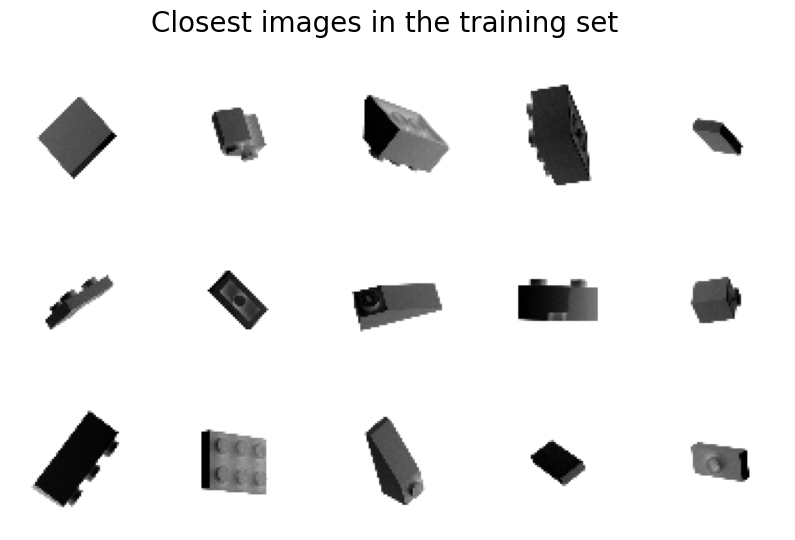

In [46]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()